In [1]:
import dotenv
import pandas as pd
import matplotlib.pyplot as plt

## Pull ElectricityMaps history

In [2]:
import os
from supabase import create_client, Client
dotenv.load_dotenv()

url: str = os.environ.get("SUPABASE_URL")
key: str = os.environ.get("SUPABASE_KEY")
supabase: Client = create_client(url, key)

In [3]:
response = supabase.table("electricitymaps-hourly").select("*").eq("testing", False).execute()

In [4]:
response.data[0].keys()

dict_keys(['id', 'created_at', 'zone', 'carbon_intensity_raw', 'power_breakdown_raw', 'testing'])

In [5]:
len(response.data)

201

In [6]:
response.data[0].keys()

dict_keys(['id', 'created_at', 'zone', 'carbon_intensity_raw', 'power_breakdown_raw', 'testing'])

In [7]:
response.data[0]['carbon_intensity_raw']['history']

[{'zone': 'CA-ON',
  'datetime': '2024-08-12T04:00:00.000Z',
  'createdAt': '2024-08-09T04:54:32.766Z',
  'updatedAt': '2024-08-12T08:48:58.186Z',
  'isEstimated': True,
  'carbonIntensity': 49,
  'estimationMethod': 'TIME_SLICER_AVERAGE',
  'emissionFactorType': 'lifecycle'},
 {'zone': 'CA-ON',
  'datetime': '2024-08-12T05:00:00.000Z',
  'createdAt': '2024-08-09T05:50:06.777Z',
  'updatedAt': '2024-08-12T07:50:29.597Z',
  'isEstimated': False,
  'carbonIntensity': 44,
  'estimationMethod': None,
  'emissionFactorType': 'lifecycle'},
 {'zone': 'CA-ON',
  'datetime': '2024-08-12T06:00:00.000Z',
  'createdAt': '2024-08-09T06:49:22.181Z',
  'updatedAt': '2024-08-12T08:48:58.186Z',
  'isEstimated': False,
  'carbonIntensity': 40,
  'estimationMethod': None,
  'emissionFactorType': 'lifecycle'},
 {'zone': 'CA-ON',
  'datetime': '2024-08-12T07:00:00.000Z',
  'createdAt': '2024-08-09T07:48:50.341Z',
  'updatedAt': '2024-08-12T09:50:15.226Z',
  'isEstimated': False,
  'carbonIntensity': 42,
  

In [8]:
# Generate a big ol' dataframe by iterating over all the responses
all_records = pd.DataFrame.from_records([
    record
    for resp in response.data
    for record in resp['carbon_intensity_raw']['history']
])
all_records.loc[all_records.zone == "CA-ON"].sort_values(by='datetime', ascending=True)


,zone,datetime,createdAt,updatedAt,isEstimated,carbonIntensity,estimationMethod,emissionFactorType
0,CA-ON,2024-08-12T04:00:00.000Z,2024-08-09T04:54:32.766Z,2024-08-12T08:48:58.186Z,True,49,TIME_SLICER_AVERAGE,lifecycle
1,CA-ON,2024-08-12T05:00:00.000Z,2024-08-09T05:50:06.777Z,2024-08-12T07:50:29.597Z,False,44,None,lifecycle
72,CA-ON,2024-08-12T05:00:00.000Z,2024-08-09T05:50:06.777Z,2024-08-12T07:50:29.597Z,False,44,None,lifecycle
2,CA-ON,2024-08-12T06:00:00.000Z,2024-08-09T06:49:22.181Z,2024-08-12T08:48:58.186Z,False,40,None,lifecycle
144,CA-ON,2024-08-12T06:00:00.000Z,2024-08-09T06:49:22.181Z,2024-08-12T08:48:58.186Z,False,40,None,lifecycle
...,...,...,...,...,...,...,...,...
4702,CA-ON,2024-08-15T19:00:00.000Z,2024-08-12T19:48:18.458Z,2024-08-15T19:49:08.063Z,True,147,TIME_SLICER_AVERAGE,lifecycle
4773,CA-ON,2024-08-15T19:00:00.000Z,2024-08-12T19:48:18.458Z,2024-08-15T20:50:36.840Z,False,142,None,lifecycle
4703,CA-ON,2024-08-15T20:00:00.000Z,2024-08-12T20:50:10.917Z,2024-08-15T19:49:08.063Z,True,151,TIME_SLICER_AVERAGE,lifecycle
4774,CA-ON,2024-08-15T20:00:00.000Z,2024-08-12T20:50:10.917Z,2024-08-15T20:51:09.528Z,True,144,TIME_SLICER_AVERAGE,lifecycle


### EDA

In [9]:
# all_records.loc[all_records.zone == "CA-ON"].groupby("datetime").count()

In [10]:
#  all_records.loc[
#     (all_records.zone == "CA-ON") & (all_records.datetime == "2024-08-12T19:00:00.000Z")
# ]

In [11]:
# all_records.drop_duplicates().groupby(["zone", "datetime"])['carbonIntensity'].count().sort_values(ascending=False)

In [12]:
# all_records.drop_duplicates().query("zone == 'US-NE-ISNE' & datetime == '2024-08-13T05:00:00.000Z'").drop_duplicates()

In [13]:
# Within each zone,datetime group, select the record with maximum updatedAt value
idx = all_records.groupby(["zone", "datetime"])['updatedAt'].idxmax()
filtered_records = all_records.loc[idx].reset_index(drop=True)

datetime_cols = ["datetime", "createdAt", "updatedAt"]
filtered_records[datetime_cols] = filtered_records[datetime_cols].apply(pd.to_datetime).apply(lambda x: x.dt.tz_convert("America/New_York"))

In [14]:
# filtered_records.query("zone == 'US-NE-ISNE' & datetime == '2024-08-13T05:00:00.000Z'")

### Plot history

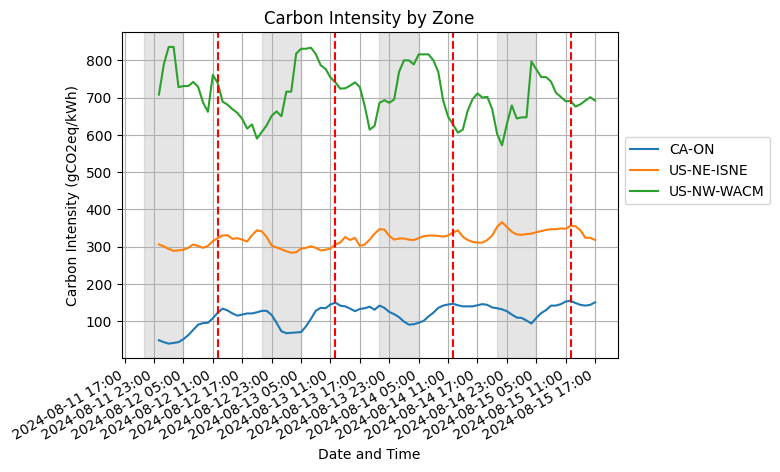

In [15]:
import matplotlib.dates as mdates
fig, ax = plt.subplots()

for zone in filtered_records.zone.unique():
    zone_data = filtered_records.loc[filtered_records.zone == zone]
    ax.plot(zone_data.datetime, zone_data.carbonIntensity, label=zone)

# Apply gray background to nighttime hours (9 PM - 5 AM)
dates = filtered_records.datetime.dt.normalize().unique()

for date in dates:
    # Define the night interval for each date
    night_start = date + pd.Timedelta(hours=-3)  # 9 PM
    night_end = date + pd.Timedelta(hours=5)    # 5 AM next day
    noon = date + pd.Timedelta(hours=12)        # 12 PM

    # Add the shaded region directly using the localized timestamps
    ax.axvspan(night_start, night_end, color='gray', alpha=0.2)
    ax.axvline(noon, color='red', linestyle='--')

# Set major locator to every hour
ax.xaxis.set_major_locator(mdates.HourLocator(interval=6, tz="America/New_York"))

# Set major formatter to show date and time
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M', tz="America/New_York"))

# Optional: rotate and align the tick labels so they look better
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
# Optional: add grid for better readability
ax.grid(True)
ax.legend(bbox_to_anchor=(1, 0.7))
ax.set_title("Carbon Intensity by Zone")
ax.set_ylabel("Carbon Intensity (gCO2eq/kWh)")
ax.set_xlabel("Date and Time")
fig.autofmt_xdate()
plt.show()

In [16]:
filtered_records.datetime.max().tz_convert("UTC")

Timestamp('2024-08-15 21:00:00+0000', tz='UTC')

## Retrieve overlapping carbon intensity from gridemissions API

In [17]:
from gridemissions import api

In [18]:
from gridemissions import config
config

{'DATA_PATH': PosixPath('/Users/alexhasha/data/gridemissions'),
 'TMP_PATH': PosixPath('/Users/alexhasha/tmp/gridemissions'),
 'ENV': 'PROD',
 'API_URL': 'https://api.gridemissions.com',
 'S3_URL': 'https://gridemissions.s3.us-east-2.amazonaws.com/',
 'DATA_PATH_LIVE': PosixPath('/Users/alexhasha/data/gridemissions/live')}

In [20]:
# Download overlapping CO2i emissions embodied in electricity consumption is the ISNE region
data = api.retrieve(
    dataset="co2i",
    region="ISNE",
    field="D",
)

DatetimeIndex(['2024-07-20 20:00:00', '2024-07-20 21:00:00',
               '2024-07-20 22:00:00', '2024-07-20 23:00:00',
               '2024-07-21 00:00:00', '2024-07-21 01:00:00',
               '2024-07-21 02:00:00', '2024-07-21 03:00:00',
               '2024-07-21 04:00:00', '2024-07-21 05:00:00',
               '2024-07-21 06:00:00', '2024-07-21 07:00:00',
               '2024-07-21 08:00:00', '2024-07-21 09:00:00',
               '2024-07-21 10:00:00', '2024-07-21 11:00:00',
               '2024-07-21 12:00:00', '2024-07-21 13:00:00',
               '2024-07-21 14:00:00', '2024-07-21 15:00:00',
               '2024-07-21 16:00:00', '2024-07-21 17:00:00',
               '2024-07-21 18:00:00', '2024-07-21 19:00:00',
               '2024-07-21 20:00:00'],
              dtype='datetime64[ns]', name='period', freq=None)
DatetimeIndex(['2024-07-20 20:00:00', '2024-07-20 21:00:00',
               '2024-07-20 22:00:00', '2024-07-20 23:00:00',
               '2024-07-21 00:00:00', '2024

AssertionError: 